In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

from numpy import pad
import tensorflow as tf
import pandas as pd
from model.Model import Model
from preprocess.preprocess import Dataset, PreprocessFrame, make_augments
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings("ignore")

In [29]:
# images size
img_width = 900
img_height = 120

# parameters of resized images
new_img_width = 350
new_img_height = 50

batch_size = 16

# default paths
WORKING_DIR = os.path.join('/home', 'HTR')
ann_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'ann')
img_path = os.path.join(WORKING_DIR, 'HKR_Dataset_Words_Public', 'img')
metadata = os.path.join(WORKING_DIR, 'metadata', 'metadata.tsv')

In [30]:
# collect metadata
# meta_collect(ann_path, metadata)

# get preprocessed metadata dataframe
df = PreprocessFrame(metadata=metadata,
                     img_height=img_height, img_width=img_width)

# Make augments file (if they exists: comment or delete line)
aug_df = None
# aug_df = make_augments(df=df, img_path=img_path, WORKING_DIR=WORKING_DIR,
#                        new_img_height=new_img_height, new_img_width=new_img_width)

# get augments metadata dataframe from original dataframe if not starting make_augments
if not isinstance(aug_df, pd.DataFrame):
    aug_df = df.copy()
    aug_df.index = aug_df.index.to_series().apply(lambda x: os.path.join('aug_1', 'aug_' + x))

train, test, val = list(Dataset(df, aug_df=aug_df,
                                test_size=0.1,
                                val_size=0.05,
                                img_path=img_path,
                                img_height=img_height,
                                img_width=img_width,
                                new_img_height=new_img_height,
                                new_img_width=new_img_width,
                                WORKING_DIR=WORKING_DIR,
                                shuffle=True,
                                random_state=12))
print(len(train), len(test), len(val))

7377 399 200


In [4]:
params = {
    'callbacks': ['checkpoint', 'csv_log', 'tb_log', 'early_stopping'],
    'metrics': ['cer', 'accuracy'],
    'checkpoint_path': os.path.join(WORKING_DIR, 'checkpoints/training_2/cp.ckpt'),
    'csv_log_path': os.path.join(WORKING_DIR, 'logs/csv_logs/log_2.csv'),
    'tb_log_path': os.path.join(WORKING_DIR, 'logs/tb_logs/log2'),
    'tb_update_freq': 200,
    'epochs': 50,
    'batch_size': batch_size,
    'early_stopping_patience': 10,
    'input_img_shape': (new_img_width, new_img_height, 1),
    'vocab_len': 75,
    'max_label_len': 22,
    'chars_path': os.path.join(os.path.split(metadata)[0], 'symbols.txt'),
    'blank': '#',
    'blank_index': 74,
    'corpus': os.path.join(os.path.split(metadata)[0], 'corpus.txt')
}

In [5]:
model = Model(params)
model.build()
model.get_summary()
#model.load_weights('checkpoints/training_2/cp.ckpt')

Model: "htr_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 350, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 350, 50, 32)  832         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 175, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 175, 25, 64)  18496       pool1[0][0]                      
__________________________________________________________________________________________

In [9]:
model.fit(train, val)

Epoch 1/50
3540/3540 [==============================] - 543s 153ms/step - loss: 24.3410 - cer: 0.6626 - accuracy: 0.0186 - val_loss: 9.6557 - val_cer: 0.2501 - val_accuracy: 0.1375

Epoch 00001: val_loss improved from inf to 9.65573, saving model to /workspace/pybooks/HTR/checkpoints/training_2/cp.ckpt
Epoch 2/50
3540/3540 [==============================] - 539s 152ms/step - loss: 8.3436 - cer: 0.2246 - accuracy: 0.2000 - val_loss: 5.3913 - val_cer: 0.1448 - val_accuracy: 0.3519

Epoch 00002: val_loss improved from 9.65573 to 5.39129, saving model to /workspace/pybooks/HTR/checkpoints/training_2/cp.ckpt
Epoch 3/50
3540/3540 [==============================] - 535s 151ms/step - loss: 5.7637 - cer: 0.1564 - accuracy: 0.3444 - val_loss: 4.2013 - val_cer: 0.1124 - val_accuracy: 0.4570

Epoch 00003: val_loss improved from 5.39129 to 4.20127, saving model to /workspace/pybooks/HTR/checkpoints/training_2/cp.ckpt
Epoch 4/50
3540/3540 [==============================] - 532s 150ms/step - loss: 4.

In [10]:
def show_history(history, indicators, nrows=2, ncols=2, width=15, height=10):
    _, ax = plt.subplots(nrows, ncols, figsize=(width, height))
    for i in range(min(len(indicators), nrows*ncols)):
        indicator_name = indicators[i]
        ax[i // ncols, i % ncols].plot(history[indicator_name])
        ax[i // ncols, i % ncols].plot(history['val_' + indicator_name])
        ax[i // ncols, i % ncols].set_title('Model ' + indicator_name)
        ax[i // ncols, i % ncols].set_ylabel(indicator_name)
        ax[i // ncols, i % ncols].set_xlabel('epoch')
        ax[i // ncols, i % ncols].legend(['Train', 'Val'], loc='lower left')
        
    plt.show()

In [59]:
# import json
# with open('history_2.json', 'r') as f:
#     h = json.load(f)

In [56]:
history = model.get_history()

In [58]:
# import json
# with open('history_2.json', 'w') as f:
#     json.dump(history, f)

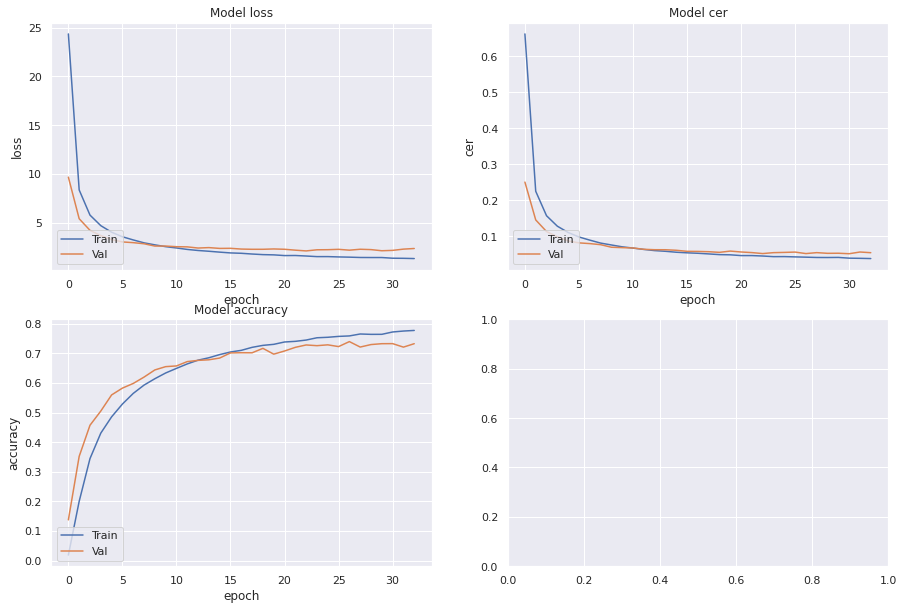

In [57]:
show_history(history, ['loss', 'cer', 'accuracy'])

In [13]:
test_metrics = model.evaluate(test)

399/399 [==============================] - 12s 30ms/step - loss: 2.1444 - cer: 0.0525 - accuracy: 0.7179


In [14]:
print(f'Метрики на тестовых данных:\n\
    ctc loss: {round(test_metrics[0], 2)}\n\
    CER: {round(test_metrics[1] * 100, 2)}%\n\
    accuracy: {round(test_metrics[2] * 100, 2)}%\n\
      ')

Метрики на тестовых данных:
    ctc loss: 2.14
    CER: 5.25%
    accuracy: 71.79%
      


In [15]:
def show_preds_on_batch(model, batch, batch_size=batch_size):
    _, ax = plt.subplots(batch_size, 1, figsize=(10, 50))

    batch_images = batch['image']
    batch_labels = batch['label']

    pred_texts = model.predict(batch)
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(model.num_to_char(label)).numpy().decode('utf-8').replace('#', '')
        orig_texts.append(label)
    for i in range(batch_size):
        img = ((batch_images[i, :, :, 0] + 0.5) * 255).numpy().astype('uint8')
        img = img.T
        title = f"Prediction: {pred_texts[i]}\nOriginal: {orig_texts[i]}"
        ax[i].set_title(title)
        ax[i].grid(False)
        ax[i].imshow(img, cmap="gray")

1/1 [==============================] - 0s 52ms/step - loss: 2.0155 - cer: 0.0680 - accuracy: 0.8125


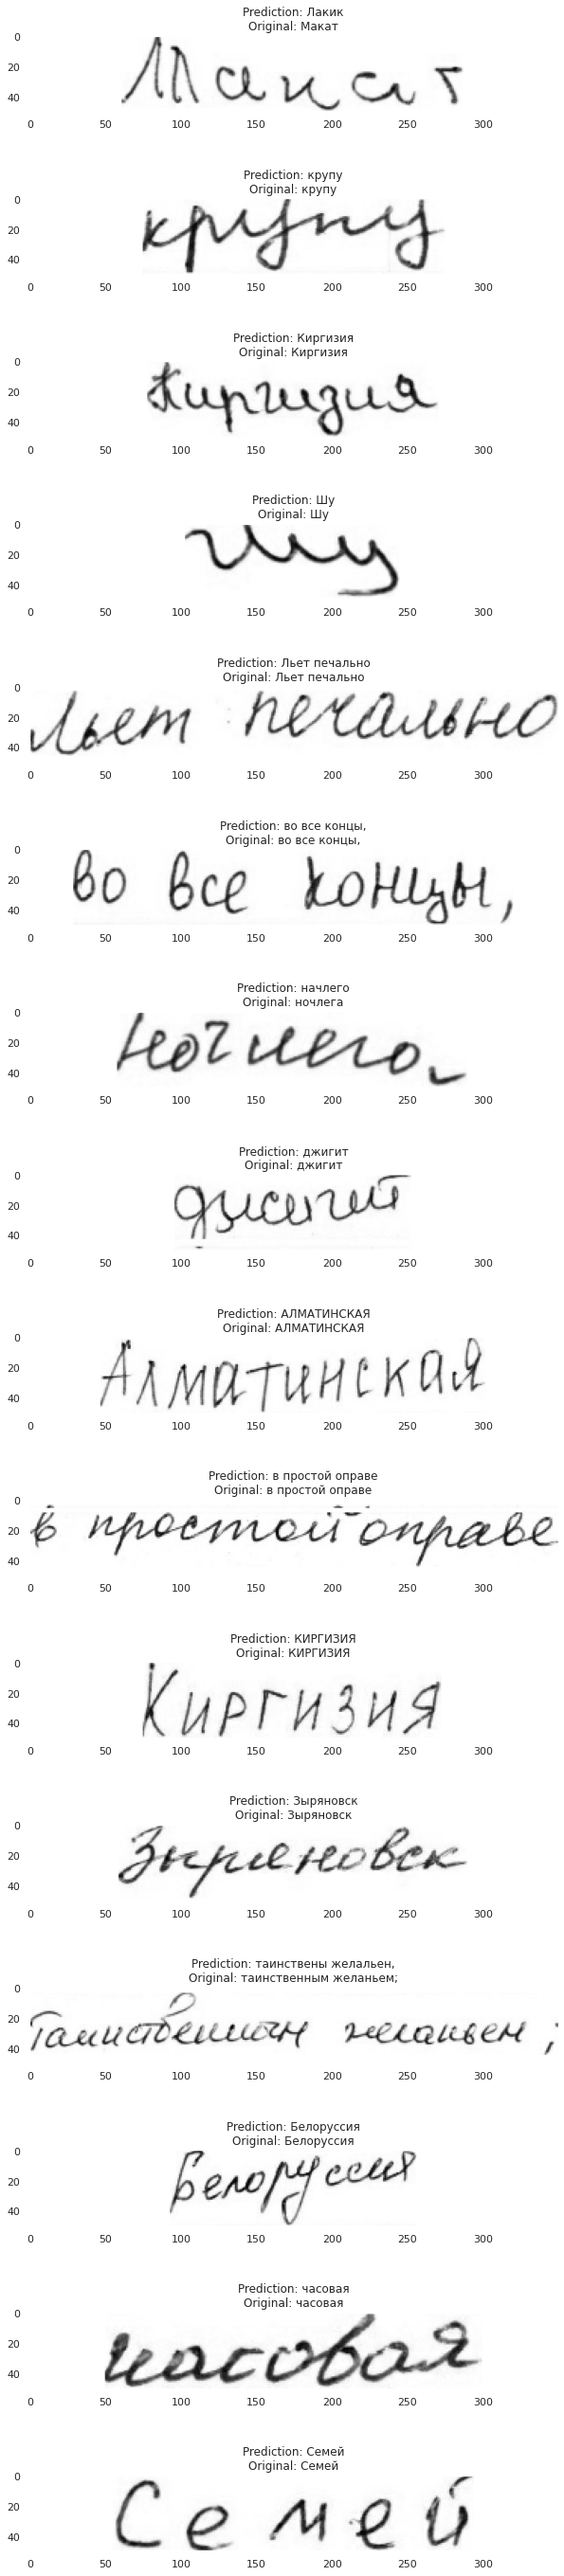

In [17]:
for batch in test.take(1):
    model.evaluate(batch)
    show_preds_on_batch(model, batch)

Попробуем посмотреть, на каких буквах чаще всего ошибается модель. Для этого построим *confusion matrix*. Так как в общем случае трудно разобрать, где модель перепутала символ, а где распознала как два или вообще не распознала - выберем лишь те пары ответ/ожидание, которые одинаковы по длине.

In [18]:
def rm_spaces(s):
    return s.replace(' ', '')

y_pred = np.empty((0, ))
y_true = np.empty((0, ))
for batch in test:
    y_pred = np.append(y_pred, model.predict(batch))
    for label in batch['label']:
        label = tf.strings.reduce_join(model.num_to_char(label)).numpy().decode('utf-8')\
                                            .replace('#', '').replace(' ', '')
        y_true = np.append(y_true, label)
y_pred = np.vectorize(rm_spaces)(y_pred)
y_comp = np.stack((y_pred, y_true), axis=-1)
y_comp

array([['Лакик', 'Макат'],
       ['крупу', 'крупу'],
       ['Киргизия', 'Киргизия'],
       ...,
       ['Глушьиснег.', 'Глушьиснег.'],
       ['РК', 'РК'],
       ['длянассадится', 'длянассадится']], dtype='<U32')

In [19]:
vec_len = np.vectorize(len)
confusions = y_comp[(y_pred != y_true) & (vec_len(y_pred) == vec_len(y_true))]
confusions

array([['Лакик', 'Макат'],
       ['начлего', 'ночлега'],
       ['Итам,гдесердцу', 'Итам,гдесердце'],
       ...,
       ['водканианисе,', 'водканаанисе,'],
       ['Чтооказалось', 'Чтооказалась'],
       ['Сзтзнениеписаиле', 'сознаниябессилья']], dtype='<U32')

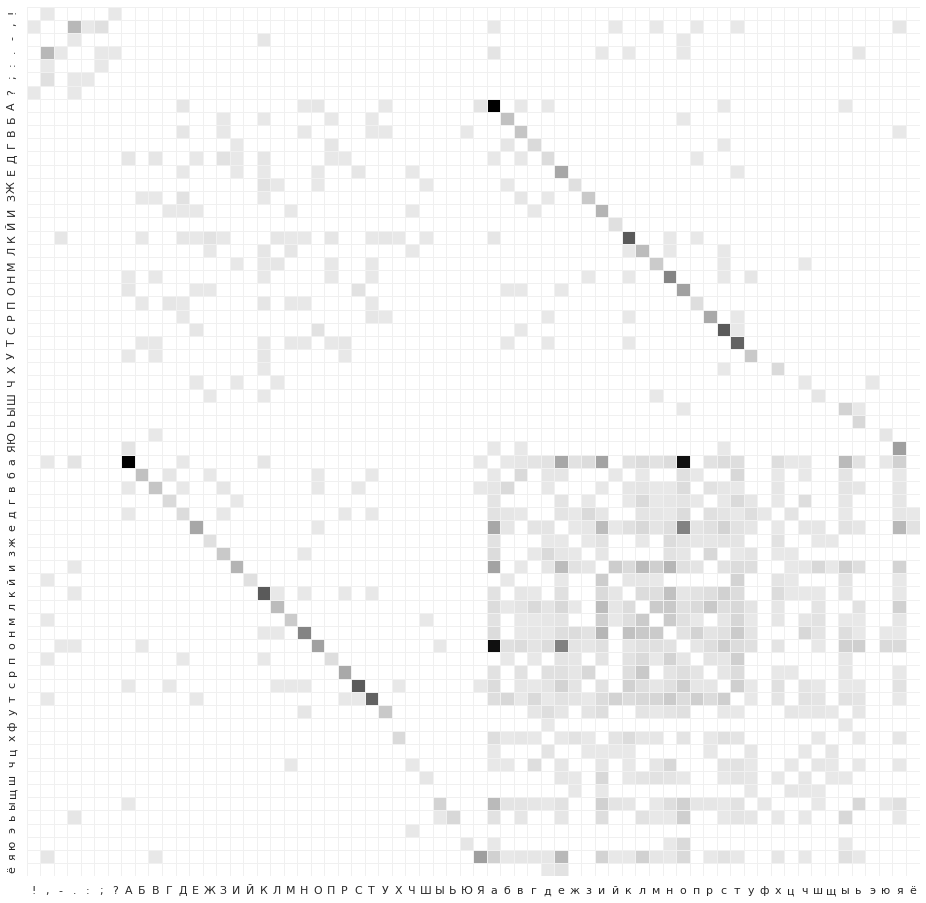

In [20]:
alphabet = set()
for pr, tr in confusions:
    for c1, c2 in zip(pr, tr):
        if c1 != c2:
            alphabet.add(c1)
            alphabet.add(c2)
alphabet = sorted(alphabet)
char_to_i = {c: i for i, c in enumerate(alphabet)}
conf_matrix = np.zeros((len(alphabet), len(alphabet)), dtype=int)
for pr, tr in confusions:
    for c1, c2 in zip(pr, tr):
        if c1 != c2:
            conf_matrix[char_to_i[c1]][char_to_i[c2]] += 1
            conf_matrix[char_to_i[c2]][char_to_i[c1]] += 1
_, ax = plt.subplots(figsize=(16, 16))
conf_matrix[conf_matrix.nonzero()] += 10 # for contrast
sns.heatmap(conf_matrix, xticklabels=alphabet, yticklabels=alphabet, ax=ax, \
            cbar=False, cmap='gray_r', linewidths=.5, linecolor='#f0f0f0')
plt.show()

Как видно из матрицы, достаточно часто модель путает большие буквы с маленькими, что в целом не настолько важная задача, учитывая то, что сама буква в конечном счете определяется верно. А судя по выведенным массивам пар, это чаще происходит тогда, когда все слово состоит из больших букв. Можно также заметить частую путаницу между **о** и **а**, **о** и **е**, **л** и **н** и другими буквами, которые схожи по написанию. Это ожидаемый результат, тк в некоторых записях это и человеку трудно отличить. В данном случае эту проблему сможет почти полностью решить постпроцессинг результата - поиск по словарю и/или оценка контекста.